# IBM Employee Attrition - Dealing with Imbalance

In [1]:
#import all required libraries for data analysis

import config

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix,confusion_matrix,classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score,accuracy_score,jaccard_score,f1_score,log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# data scaling
from sklearn.preprocessing import StandardScaler


# dependencies for Data Augmentation
import copy
from collections import Counter
from numpy import where
from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline

# dependencies to read data from pgadmin
from sqlalchemy import create_engine
from sqlalchemy import inspect
import psycopg2 as pg
import pandas.io.sql as psql

# 1. Exploring Data

In [2]:
# Conncet to postgresql dataBase table
protocol = 'postgresql'
username = 'postgres'
password = config.password
host = 'localhost'
port = 5432
database_name = 'Project4_db'

pg_connection = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'


In [3]:

#Create DataFrame from SQL table 
pg_connection = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
conn = pg.connect(pg_connection)
raw_ibm_df = psql.read_sql('SELECT * FROM ibm_employee_data', conn)

# Display all the DataFrame Columns 
pd.options.display.max_columns = None
display(raw_ibm_df)


,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,employeenumber,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,over18,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,Male,63,2,2,Sales Executive,2,Married,5390,13243,2,Y,No,14,3,4,80,0,17,3,2,9,6,0,8


In [4]:
raw_ibm_df.columns


Index(['age', 'attrition', 'businesstravel', 'dailyrate', 'department',
       'distancefromhome', 'education', 'educationfield', 'employeecount',
       'employeenumber', 'environmentsatisfaction', 'gender', 'hourlyrate',
       'jobinvolvement', 'joblevel', 'jobrole', 'jobsatisfaction',
       'maritalstatus', 'monthlyincome', 'monthlyrate', 'numcompaniesworked',
       'over18', 'overtime', 'percentsalaryhike', 'performancerating',
       'relationshipsatisfaction', 'standardhours', 'stockoptionlevel',
       'totalworkingyears', 'trainingtimeslastyear', 'worklifebalance',
       'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion',
       'yearswithcurrmanager'],
      dtype='object')

In [5]:
df = raw_ibm_df.rename(columns = {'age' : 'Age', 
                                        'attrition' :'Attrition', 
                                        'businesstravel' : 'BusinessTravel', 
                                        'dailyrate' : 'DailyRate', 
                                        'department' : 'Department',
                                        'distancefromhome' : 'DistanceFromHome', 
                                        'education' : 'Education', 
                                        'educationfield' : 'EducationField', 
                                        'employeecount' : 'EmployeeCount',
                                        'employeenumber' : 'EmployeeNumber', 
                                        'environmentsatisfaction' : 'EnvironmentSatisfaction', 
                                        'gender' : 'Gender', 
                                        'hourlyrate' : 'HourlyRate',
                                        'jobinvolvement' : 'JobInvolvement', 
                                        'joblevel' : 'JobLevel', 
                                        'jobrole' : 'JobRole', 
                                        'jobsatisfaction' : 'JobSatisfaction',
                                        'maritalstatus' : 'MaritalStatus', 
                                        'monthlyincome' : 'MonthlyIncome', 
                                        'monthlyrate' : 'MonthlyRate', 
                                        'numcompaniesworked' : 'NumCompaniesWorked',
                                        'over18' : 'Over18', 
                                        'overtime' : 'OverTime', 
                                        'percentsalaryhike' : 'PercentSalaryHike', 
                                        'performancerating' : 'PerformanceRating',
                                        'relationshipsatisfaction' : 'RelationshipSatisfaction', 
                                        'standardhours' : 'StandardHours', 
                                        'stockoptionlevel' : 'StockOptionLevel',
                                        'totalworkingyears' : 'TotalWorkingYears', 
                                        'trainingtimeslastyear' : 'TrainingTimesLastYear', 
                                        'worklifebalance' : 'WorkLifeBalance',
                                        'yearsatcompany' : 'YearsAtCompany', 
                                        'yearsincurrentrole': 'YearsInCurrentRole', 
                                        'yearssincelastpromotion' : 'YearsSinceLastPromotion',
                                        'yearswithcurrmanager' : 'YearsWithCurrManager'
})
display(df.head())

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [6]:
# check datatype and other information for each feature
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.0,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.0,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.0,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.0,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.0,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.0,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.0,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.0,2.0,3.00,5.0
JobSatisfaction,1470.0,2.728571,1.102846,1.0,2.0,3.0,4.00,4.0


In [7]:
# the shape of the dataset
df.shape

(1470, 35)

In [8]:
# check missing data for each feature
df[df.isnull().any(axis=1)]

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager


In [9]:
# count unique values of each features
df.nunique()

Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1470
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1349
MonthlyRate                 1427
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBa

In [10]:
# Drop Columns with only 1 value in all rows and Employee number that is unique for all.
df = df.drop(['Over18','EmployeeNumber', 'EmployeeCount', 'StandardHours'], axis = 1)
print(df.shape)
df.head()

(1470, 31)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2


In [11]:
# separate features into numerical and non numerical groups
df.columns.to_series().groupby(df.dtypes).groups

{dtype('int64'): Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
        'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
        'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
        'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
        'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
        'YearsSinceLastPromotion', 'YearsWithCurrManager'],
       dtype='object'),
 dtype('O'): Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
        'JobRole', 'MaritalStatus', 'OverTime'],
       dtype='object')}

In [12]:
# Seperating the numerical and categorical columns
categorical = df.select_dtypes(include = 'object')
print(categorical.columns)


Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'OverTime'],
      dtype='object')


In [13]:
numerical = df.select_dtypes(include=['float64','int64'])
print((numerical.columns))

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')


# 2. Distribution of the dataset

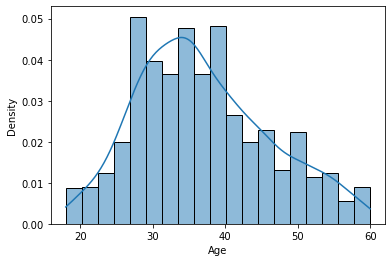

In [14]:
sns.histplot(df['Age'], kde=True, stat="density")
plt.savefig('outputs/Age_distribution.png')

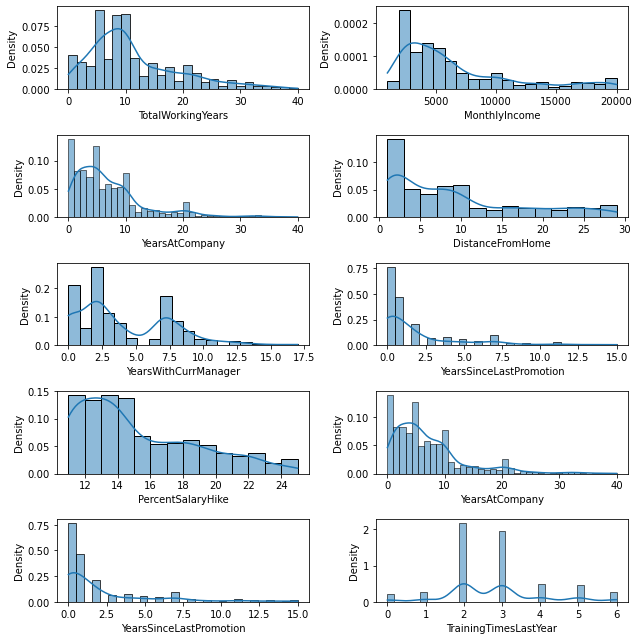

In [15]:
fig, ax = plt.subplots(5,2, figsize=(9,9))
sns.histplot(df['TotalWorkingYears'], kde=True, stat="density", ax = ax[0,0])
sns.histplot(df['MonthlyIncome'], kde=True, stat="density", ax = ax[0,1])
sns.histplot(df['YearsAtCompany'], kde=True, stat="density", ax = ax[1,0])
sns.histplot(df['DistanceFromHome'], kde=True, stat="density", ax = ax[1,1])
sns.histplot(df['YearsWithCurrManager'], kde=True, stat="density", ax = ax[2,0])
sns.histplot(df['YearsSinceLastPromotion'], kde=True, stat="density", ax = ax[2,1])
sns.histplot(df['PercentSalaryHike'], kde=True, stat="density", ax = ax[3,0])
sns.histplot(df['YearsAtCompany'], kde=True, stat="density", ax = ax[3,1])
sns.histplot(df['YearsSinceLastPromotion'], kde=True, stat="density", ax = ax[4,0])
sns.histplot(df['TrainingTimesLastYear'], kde=True, stat="density", ax = ax[4,1])
plt.tight_layout()
plt.savefig('outputs/dataset_distribution.png')
plt.show()

# 3. Feature engineering

In [16]:
# tranform binary feature into 0 and 1
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})

In [17]:
# Check for data imbalance
df['Attrition'].value_counts()/df.shape[0]*100

0    83.877551
1    16.122449
Name: Attrition, dtype: float64

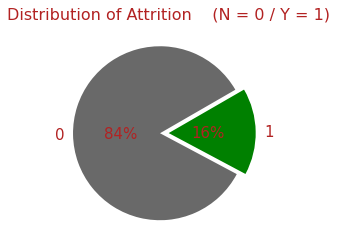

In [38]:
# Plot pie chart of ATTRITION is show if data is balanced "OR" imbalanced

df['Attrition'].value_counts(normalize=True).plot(kind='pie', pctdistance=0.45, autopct="%.0f%%", explode = (0.1, 0), startangle=30, colors = ['dimgrey', 'green'] , fontsize=15, textprops={'color':"firebrick"})

plt.title(("Distribution of Attrition    (N = 0 / Y = 1)"),fontsize=16, color = 'firebrick')

plt.xlabel("")
plt.ylabel("");

# save heatmap as .png file
# plt.savefig('attrition_pie.png', dpi=300, bbox_inches='tight')

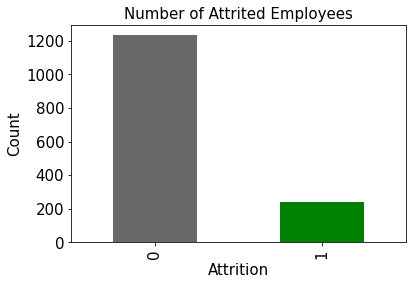

In [19]:
df['Attrition'].value_counts(normalize=False).plot(kind='bar', fontsize=15, color = ['dimgrey', 'green'])
plt.xlabel("Attrition", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title('Number of Attrited Employees',fontsize=15);

#### Data imbalance detected 84% to 16%

In [20]:
# check correlation between numerical features and target variable
corr_score = df[['Age', 'DailyRate', 'DistanceFromHome', 'Education',
        'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
        'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
        'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
        'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
        'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition']].corr()
corr_score

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
Age,1.000000,0.010661,-0.001686,0.208034,0.010146,0.024287,0.029820,0.509604,-0.004892,0.497855,0.028051,0.299635,0.003634,0.001904,0.053535,0.037510,0.680381,-0.019621,-0.021490,0.311309,0.212901,0.216513,0.202089,-0.159205
DailyRate,0.010661,1.000000,-0.004985,-0.016806,0.018355,0.023381,0.046135,0.002966,0.030571,0.007707,-0.032182,0.038153,0.022704,0.000473,0.007846,0.042143,0.014515,0.002453,-0.037848,-0.034055,0.009932,-0.033229,-0.026363,-0.056652
DistanceFromHome,-0.001686,-0.004985,1.000000,0.021042,-0.016075,0.031131,0.008783,0.005303,-0.003669,-0.017014,0.027473,-0.029251,0.040235,0.027110,0.006557,0.044872,0.004628,-0.036942,-0.026556,0.009508,0.018845,0.010029,0.014406,0.077924
Education,0.208034,-0.016806,0.021042,1.000000,-0.027128,0.016775,0.042438,0.101589,-0.011296,0.094961,-0.026084,0.126317,-0.011111,-0.024539,-0.009118,0.018422,0.148280,-0.025100,0.009819,0.069114,0.060236,0.054254,0.069065,-0.031373
EnvironmentSatisfaction,0.010146,0.018355,-0.016075,-0.027128,1.000000,-0.049857,-0.008278,0.001212,-0.006784,-0.006259,0.037600,0.012594,-0.031701,-0.029548,0.007665,0.003432,-0.002693,-0.019359,0.027627,0.001458,0.018007,0.016194,-0.004999,-0.103369
HourlyRate,0.024287,0.023381,0.031131,0.016775,-0.049857,1.000000,0.042861,-0.027853,-0.071335,-0.015794,-0.015297,0.022157,-0.009062,-0.002172,0.001330,0.050263,-0.002334,-0.008548,-0.004607,-0.019582,-0.024106,-0.026716,-0.020123,-0.006846
JobInvolvement,0.029820,0.046135,0.008783,0.042438,-0.008278,0.042861,1.000000,-0.012630,-0.021476,-0.015271,-0.016322,0.015012,-0.017205,-0.029071,0.034297,0.021523,-0.005533,-0.015338,-0.014617,-0.021355,0.008717,-0.024184,0.025976,-0.130016
JobLevel,0.509604,0.002966,0.005303,0.101589,0.001212,-0.027853,-0.012630,1.000000,-0.001944,0.950300,0.039563,0.142501,-0.034730,-0.021222,0.021642,0.013984,0.782208,-0.018191,0.037818,0.534739,0.389447,0.353885,0.375281,-0.169105
JobSatisfaction,-0.004892,0.030571,-0.003669,-0.011296,-0.006784,-0.071335,-0.021476,-0.001944,1.000000,-0.007157,0.000644,-0.055699,0.020002,0.002297,-0.012454,0.010690,-0.020185,-0.005779,-0.019459,-0.003803,-0.002305,-0.018214,-0.027656,-0.103481
MonthlyIncome,0.497855,0.007707,-0.017014,0.094961,-0.006259,-0.015794,-0.015271,0.950300,-0.007157,1.000000,0.034814,0.149515,-0.027269,-0.017120,0.025873,0.005408,0.772893,-0.021736,0.030683,0.514285,0.363818,0.344978,0.344079,-0.159840


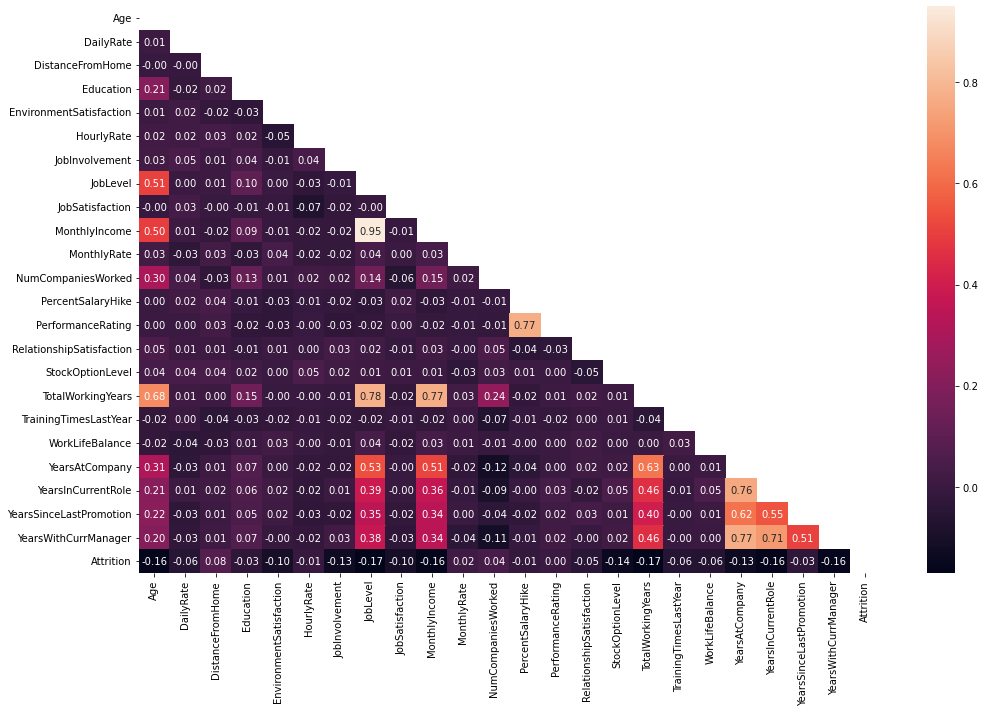

In [21]:
# visualization of correlation relationships
plt.figure(figsize=(15, 10))
mask = np.triu(corr_score)
sns.heatmap(corr_score,annot = True, fmt = '.2f',mask = mask)
plt.tight_layout()
plt.savefig('outputs/correlation_heatmap.png')

# 4. Splitting the Data

In [22]:
# Drop the target column and get a clean dataframe with features
X = df.drop(columns = ['Attrition']) #df_clean in V1
y = df['Attrition'] # y ion V1


In [23]:
# apply one hot encoding to non numerical features
X_trans = pd.get_dummies(X, columns = ['BusinessTravel', 'Gender','MaritalStatus'], drop_first = True)
X_trans = pd.get_dummies(X)
X_trans.head()


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,41,1102,1,2,2,94,3,2,4,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
1,49,279,8,1,3,61,2,2,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
2,37,1373,2,2,4,92,2,1,3,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
3,33,1392,3,4,4,56,3,1,3,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,27,591,2,1,1,40,3,1,2,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


In [24]:
# check the columns we have after feature engineering
print(list(X_trans.columns))

['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales', 'EducationField_Human Resources', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'Gender_Female', 'Gender_Male', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director',

In [25]:
# check the shape for the new dataset
X_trans.shape

(1470, 50)

# 5. Model training and performance evaluation

In [26]:
# Use test_size of 0.25 (25%) 
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, stratify = y, random_state=6)  

print('Training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('Test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')


Training data has 1102 observation with 30 features
Test data has 368 observation with 30 features


In [27]:
# filter out features that needs to be standarized
col_tobe_standard = ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 
                   'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 
                   'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 
                   'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 
                   'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 
                   'YearsWithCurrManager']

In [28]:
# standarization on numercial features so that all the numerical features are having the same type of normal distribution
scaler = StandardScaler()
for col in col_tobe_standard:
    X[col] = X[col].astype(float)
    X[[col]] = scaler.fit_transform(X[[col]])
X.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.446350,Travel_Rarely,0.742527,Sales,-1.010909,-0.891688,Life Sciences,-0.660531,Female,1.383138,0.379672,-0.057788,Sales Executive,1.153254,Single,-0.108350,0.726020,2.125136,1,-1.150554,-0.426230,-1.584178,-0.932014,-0.421642,-2.171982,-2.493820,-0.164613,-0.063296,-0.679146,0.245834
1,1.322365,Travel_Frequently,-1.297775,Research & Development,-0.147150,-1.868426,Life Sciences,0.254625,Male,-0.240677,-1.026167,-0.057788,Research Scientist,-0.660853,Married,-0.291719,1.488876,-0.678049,0,2.129306,2.346151,1.191438,0.241988,-0.164511,0.155707,0.338096,0.488508,0.764998,-0.368715,0.806541
2,0.008343,Travel_Rarely,1.414363,Research & Development,-0.887515,-0.891688,Other,1.169781,Male,1.284725,-1.026167,-0.961486,Laboratory Technician,0.246200,Single,-0.937654,-1.674841,1.324226,1,-0.057267,-0.426230,-0.658973,-0.932014,-0.550208,0.155707,0.338096,-1.144294,-1.167687,-0.679146,-1.155935
3,-0.429664,Travel_Frequently,1.461466,Research & Development,-0.764121,1.061787,Life Sciences,1.169781,Female,-0.486709,0.379672,-0.961486,Research Scientist,0.246200,Married,-0.763634,1.243211,-0.678049,1,-1.150554,-0.426230,0.266233,-0.932014,-0.421642,0.155707,0.338096,0.161947,0.764998,0.252146,-1.155935
4,-1.086676,Travel_Rarely,-0.524295,Research & Development,-0.887515,-1.868426,Medical,-1.575686,Male,-1.274014,0.379672,-0.961486,Laboratory Technician,-0.660853,Married,-0.644858,0.325900,2.525591,0,-0.877232,-0.426230,1.191438,0.241988,-0.678774,0.155707,0.338096,-0.817734,-0.615492,-0.058285,-0.595227


In [29]:
# build 6 different machine learning models with the same random state if applicable
lr = LogisticRegression(random_state = 6, solver='liblinear', max_iter=1000)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state = 6)
dt = DecisionTreeClassifier(random_state = 6)
mlp = MLPClassifier(random_state = 6)
xg = xgb.XGBClassifier(random_state = 6)

In [30]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV

from sklearn.metrics import recall_score

In [31]:
transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(drop = 'first'), ['BusinessTravel', 'Department', 'EducationField', 'Gender',
                                                'JobRole', 'MaritalStatus', 'OverTime']),
], remainder = 'passthrough')

In [32]:
# import warnings
# warnings.filterwarnings("ignore")

In [33]:
# Cross Validation

lr_pipe = Pipeline([('transformer', transformer), ('lr', lr)])
knn_pipe = Pipeline([('transformer', transformer), ('scale', MinMaxScaler()), ('knn', knn)])
rf_pipe = Pipeline([('transformer', transformer), ('rf', rf)])
dt_pipe = Pipeline([('transformer', transformer), ('dt', dt)])
mlp_pipe = Pipeline([('transformer', transformer), ('mlp', mlp)])
xg_pipe = Pipeline([('transformer', transformer), ('xg', xg)])


def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_train, y_train, cv = skfold, scoring = metric)
    return model_cv

lr_pipe_cv = model_evaluation(lr_pipe, 'recall')
knn_pipe_cv = model_evaluation(knn_pipe, 'recall')
rf_pipe_cv = model_evaluation(rf_pipe, 'recall')
dt_pipe_cv = model_evaluation(dt_pipe, 'recall')
mlp_pipe_cv = model_evaluation(mlp_pipe, 'recall')
xg_pipe_cv = model_evaluation(xg_pipe, 'recall')


for model in [lr_pipe, knn_pipe, rf_pipe, dt_pipe, mlp_pipe, xg_pipe ]:
    model.fit(X_train, y_train)
    
score_mean = [lr_pipe_cv.mean(), knn_pipe_cv.mean(), rf_pipe_cv.mean(), dt_pipe_cv.mean(), mlp_pipe_cv.mean(), xg_pipe_cv.mean()]
score_std = [lr_pipe_cv.mean(), knn_pipe_cv.std(), rf_pipe_cv.std(), dt_pipe_cv.std(), mlp_pipe_cv.std(), xg_pipe_cv.std()]
score_recall_score = [recall_score(y_test, lr_pipe.predict(X_test)),
                    recall_score(y_test, knn_pipe.predict(X_test)), 
                    recall_score(y_test, rf_pipe.predict(X_test)), 
                    recall_score(y_test, dt_pipe.predict(X_test)),
                    recall_score(y_test, mlp_pipe.predict(X_test)),
                    recall_score(y_test, xg_pipe.predict(X_test)),
                    ]
method_name = ['Logistic Regression', 'KNN Classifier', 'Random Forest Classifier', 
                'Decision Tree Classifier', 'MLP Classifier', 'XG Boost']
cv_summary = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'recall score': score_recall_score
})
cv_summary

,method,mean score,std score,recall score
0,Logistic Regression,0.315079,0.315079,0.322034
1,KNN Classifier,0.140794,0.032205,0.169492
2,Random Forest Classifier,0.106984,0.060737,0.220339
3,Decision Tree Classifier,0.400159,0.100461,0.474576
4,MLP Classifier,0.196984,0.095284,0.474576
5,XG Boost,0.297937,0.043541,0.322034


In [34]:
# Handling Imbalance - Under Sampling  

rus = RandomUnderSampler(random_state = 6)
X_under, y_under = rus.fit_resample(X_train, y_train) 

lr_pipe_under = Pipeline([('transformer', transformer), ('rus', rus), ('lr', lr)])
knn_pipe_under = Pipeline([('transformer', transformer), ('scale', MinMaxScaler()), ('rus', rus),('knn', knn)])
rf_pipe_under = Pipeline([('transformer', transformer), ('rus', rus),('rf', rf)])
dt_pipe_under = Pipeline([('transformer', transformer), ('rus', rus),('dt', dt)])
mlp_pipe_under = Pipeline([('transformer', transformer), ('rus', rus),('mlp', mlp)])
xg_pipe_under = Pipeline([('transformer', transformer), ('rus', rus),('xg', xg)])

def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_train, y_train, cv = skfold, scoring = metric)
    return model_cv

logreg_pipe_cv = model_evaluation(lr_pipe_under, 'recall')
knn_pipe_cv = model_evaluation(knn_pipe_under, 'recall')
rf_pipe_cv = model_evaluation(rf_pipe_under, 'recall')
dt_pipe_cv = model_evaluation(dt_pipe_under, 'recall')
mlp_pipe_cv = model_evaluation(mlp_pipe_under, 'recall')
xg_pipe_cv = model_evaluation(xg_pipe_under, 'recall')

for model in [lr_pipe_under, knn_pipe_under, rf_pipe_under, dt_pipe_under, mlp_pipe_under, xg_pipe_under ]:
    model.fit(X_train, y_train)
    
score_mean = [lr_pipe_cv.mean(), knn_pipe_cv.mean(), rf_pipe_cv.mean(), dt_pipe_cv.mean(), mlp_pipe_cv.mean(), xg_pipe_cv.mean()]
score_std = [logreg_pipe_cv.mean(), knn_pipe_cv.std(), rf_pipe_cv.std(), dt_pipe_cv.std(), mlp_pipe_cv.std(), xg_pipe_cv.std()]
score_recall_score = [recall_score(y_test, lr_pipe_under.predict(X_test)),
                    recall_score(y_test, knn_pipe_under.predict(X_test)), 
                    recall_score(y_test, rf_pipe_under.predict(X_test)), 
                    recall_score(y_test, dt_pipe_under.predict(X_test)),
                    recall_score(y_test, mlp_pipe_under.predict(X_test)),
                    recall_score(y_test, xg_pipe_under.predict(X_test)),
                    ]
method_name = ['Logistic Regression UnderSampling', 'KNN Classifier UnderSampling', 'Random Forest Classifier UnderSampling', 
                'Decision Tree Classifier UnderSampling', 'MLP Classifier UnderSampling', 'XG Boost UnderSampling']
under_summary = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'recall score': score_recall_score
})
under_summary

,method,mean score,std score,recall score
0,Logistic Regression UnderSampling,0.315079,0.702063,0.779661
1,KNN Classifier UnderSampling,0.568730,0.127682,0.762712
2,Random Forest Classifier UnderSampling,0.697460,0.079316,0.762712
3,Decision Tree Classifier UnderSampling,0.674127,0.094545,0.559322
4,MLP Classifier UnderSampling,0.592381,0.205470,0.966102
5,XG Boost UnderSampling,0.714127,0.087748,0.728814


In [35]:
# Handling Imbalance - Over Sampling

ros = RandomOverSampler(random_state = 6)
X_over, y_over = ros.fit_resample(X_train, y_train) 

lr_pipe_over = Pipeline([('transformer', transformer), ('ros', ros), ('lr', lr)])
knn_pipe_over = Pipeline([('transformer', transformer), ('scale', MinMaxScaler()), ('ros', rus),('knn', knn)])
rf_pipe_over = Pipeline([('transformer', transformer), ('ros', ros),('rf', rf)])
dt_pipe_over = Pipeline([('transformer', transformer), ('ros', ros),('dt', dt)])
mlp_pipe_over = Pipeline([('transformer', transformer), ('ros', ros),('mlp', mlp)])
xg_pipe_over = Pipeline([('transformer', transformer), ('ros', ros),('xg', xg)])

def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_train, y_train, cv = skfold, scoring = metric)
    return model_cv

lr_pipe_cv = model_evaluation(lr_pipe_over, 'recall')
knn_pipe_cv = model_evaluation(knn_pipe_over, 'recall')
rf_pipe_cv = model_evaluation(rf_pipe_over, 'recall')
dt_pipe_cv = model_evaluation(dt_pipe_over, 'recall')
mlp_pipe_cv = model_evaluation(mlp_pipe_over, 'recall')
xg_pipe_cv = model_evaluation(xg_pipe_over, 'recall')

for model in [lr_pipe_over, knn_pipe_over, rf_pipe_over, dt_pipe_over, mlp_pipe_over, xg_pipe_over ]:
    model.fit(X_train, y_train)
    
score_mean = [logreg_pipe_cv.mean(), knn_pipe_cv.mean(), rf_pipe_cv.mean(), dt_pipe_cv.mean(), mlp_pipe_cv.mean(), xg_pipe_cv.mean()]
score_std = [logreg_pipe_cv.std(), knn_pipe_cv.std(), rf_pipe_cv.std(), dt_pipe_cv.std(), mlp_pipe_cv.std(), xg_pipe_cv.std()]
score_recall_score = [recall_score(y_test, lr_pipe_over.predict(X_test)),
                    recall_score(y_test, knn_pipe_over.predict(X_test)), 
                    recall_score(y_test, rf_pipe_over.predict(X_test)), 
                    recall_score(y_test, dt_pipe_over.predict(X_test)),
                    recall_score(y_test, mlp_pipe_over.predict(X_test)),
                    recall_score(y_test, xg_pipe_over.predict(X_test)),
                    ]
method_name = ['Logistic Regression OverSampling', 'KNN Classifier OverSampling', 'Random Forest Classifier OverSampling', 
                'Decision Tree Classifier OverSampling', 'MLP Classifier OverSampling', 'XG Boost OverSampling']
over_summary = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'recall score': score_recall_score
})
over_summary

,method,mean score,std score,recall score
0,Logistic Regression OverSampling,0.702063,0.063689,0.796610
1,KNN Classifier OverSampling,0.568730,0.127682,0.762712
2,Random Forest Classifier OverSampling,0.202222,0.045051,0.338983
3,Decision Tree Classifier OverSampling,0.263651,0.073520,0.491525
4,MLP Classifier OverSampling,0.752540,0.180019,0.949153
5,XG Boost OverSampling,0.330952,0.059370,0.474576


In [36]:
# Hyper Parameter Tuning on Logistic Regression

estimator = Pipeline([
    ('transformer', transformer),
    ('ros', ros),
    ('model', LogisticRegression())
])

hyperparam_space = {
    'model__C': [100, 10, 1, 0.1, 0.01, 0.001],
    'model__solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'model__max_iter': [50, 100, 150, 200, 250 ,500],
    'model__random_state': [6]
}

random = RandomizedSearchCV(
                estimator,
                param_distributions = hyperparam_space,
                cv = StratifiedKFold(n_splits = 5),
                scoring = 'recall',
                n_iter = 100,
                n_jobs = -1)

random.fit(X_train, y_train)

print('best score', random.best_score_)
print('best param', random.best_params_)

best score 0.7477777777777778
best param {'model__solver': 'newton-cg', 'model__random_state': 6, 'model__max_iter': 250, 'model__C': 0.1}


# 6. Results

In [37]:
# Summary

estimator.fit(X_train, y_train)
y_pred_estimator = estimator.predict(X_test)
recall_estimator = recall_score(y_test, y_pred_estimator)

random.best_estimator_.fit(X_train, y_train)
y_pred_random = random.best_estimator_.predict(X_test)
recall_best_estimator = recall_score(y_test, y_pred_random)

score_list = [recall_estimator, recall_best_estimator]
method_name = ['Logistic Regression OverSampling Before Tuning', 'Logistic Regression OverSampling After Tuning']
best_summary = pd.DataFrame({
    'method': method_name,
    'score': score_list
})
best_summary

c:\Users\dalem\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


,method,score
0,Logistic Regression OverSampling Before Tuning,0.711864
1,Logistic Regression OverSampling After Tuning,0.796610
